In [9]:
# Core Libraries
import re, string, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Sklearn Models & Tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import (
RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
classification_report, confusion_matrix
)


# LightGBM
from lightgbm import LGBMClassifier


# NLTK for preprocessing
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
def clean_text(text):
    """Rigorous preprocessing: lowercase, remove HTML, punctuation, stopwords, lemmatize"""
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text) # HTML tags
    text = re.sub(r"[^a-z\s]", " ", text) # keep only letters
    tokens = nltk.word_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

In [56]:
# Load dataset
df = pd.read_csv("train.csv")
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


# Smart 50k subset selection
df["has_label"] = df[labels].sum(axis=1) > 0
toxic_rows = df[df["has_label"]].copy()
clean_rows = df[~df["has_label"]].copy()


target_size = 50000
needed_clean = max(0, target_size - len(toxic_rows))


clean_sample = clean_rows.sample(n=min(needed_clean, len(clean_rows)), random_state=42)
df_reduced = pd.concat([toxic_rows, clean_sample]).reset_index(drop=True)
df_reduced = df_reduced.drop(columns=["has_label"])

df_reduced.head(10)
print("Original size:", len(df))
print("Reduced size:", len(df_reduced))
print("Positive examples kept (>=1 label):", len(toxic_rows))
print("Negative examples sampled:", len(clean_sample))

Original size: 159571
Reduced size: 50000
Positive examples kept (>=1 label): 16225
Negative examples sampled: 33775


In [58]:
df_identity_hate = df_reduced[df_reduced['identity_hate'] == 1]
print(df_identity_hate.shape)
df_identity_hate.head()


(1405, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
3,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
14,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
18,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
24,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1
26,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1


In [11]:
df_reduced["clean_text"] = df_reduced["comment_text"].apply(clean_text)



# Split Data
X = df_reduced["clean_text"]
y = df_reduced[labels]


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=20000, stop_words="english", ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

In [37]:
def evaluate_model(name, model, X_train, y_train, X_valid, y_valid):
    start = time.time()
    clf = OneVsRestClassifier(model, n_jobs=-1)
    clf.fit(X_train, y_train)


    # Predict probabilities or decision function
    if hasattr(clf, "predict_proba"):
        y_pred = clf.predict_proba(X_valid)
    else:
        y_pred = clf.decision_function(X_valid)
        y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())


    # Threshold 0.5 for classification
    y_pred_bin = (y_pred >= 0.5).astype(int)


    # Metrics
    auc = roc_auc_score(y_valid, y_pred, average="macro")
    acc = accuracy_score(y_valid, y_pred_bin)
    prec = precision_score(y_valid, y_pred_bin, average="macro", zero_division=0)
    rec = recall_score(y_valid, y_pred_bin, average="macro", zero_division=0)
    f1 = f1_score(y_valid, y_pred_bin, average="macro", zero_division=0)


    return [name, auc, acc, prec, rec, f1, round(time.time()-start, 2)], clf

In [38]:
models = {}
results = []


# List of classical models
classical_models = {
"Logistic Regression": LogisticRegression(C=2, solver="lbfgs", max_iter=200),
"Naive Bayes": MultinomialNB(),
"Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1),
"Linear SVC": LinearSVC(C=1.0, max_iter=2000),
"Ridge Classifier": RidgeClassifier(alpha=1.0),
"Decision Tree": DecisionTreeClassifier(max_depth=30, random_state=42),
"KNN": KNeighborsClassifier(n_neighbors=10),
"SGD Classifier": SGDClassifier(max_iter=1000, tol=1e-3),
"Extra Trees": ExtraTreesClassifier(n_estimators=200, n_jobs=-1),
"AdaBoost": AdaBoostClassifier(n_estimators=200),
"Gradient Boosting": GradientBoostingClassifier(n_estimators=200)
}


# Train and evaluate
for name, model in classical_models.items():
    res, clf = evaluate_model(name, model, X_train_tfidf, y_train, X_valid_tfidf, y_valid)
    results.append(res)

    models[name] = clf

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [39]:
from lightgbm.callback import early_stopping


def train_lightgbm_multilabel(X_train, y_train, X_valid, y_valid, labels):
    aucs, accs, precs, recs, f1s = [], [], [], [], []
    models = {}
    start = time.time()


    for label in labels:
        lgb = LGBMClassifier(
            n_estimators=200,
            learning_rate=0.1,
            num_leaves=32,
            n_jobs=-1,
            force_col_wise=True,
            random_state=42
        )
        lgb.fit(
            X_train, y_train[label],
            eval_set=[(X_valid, y_valid[label])],
            eval_metric="auc",
            callbacks=[early_stopping(stopping_rounds=20, verbose=-1)]
        )


        y_pred = lgb.predict_proba(X_valid)[:,1]
        y_bin = (y_pred >= 0.5).astype(int)


        aucs.append(roc_auc_score(y_valid[label], y_pred))
        accs.append(accuracy_score(y_valid[label], y_bin))
        precs.append(precision_score(y_valid[label], y_bin, zero_division=0))
        recs.append(recall_score(y_valid[label], y_bin, zero_division=0))
        f1s.append(f1_score(y_valid[label], y_bin, zero_division=0))
        models[label] = lgb


    return ["LightGBM", np.mean(aucs), np.mean(accs), np.mean(precs), np.mean(recs), np.mean(f1s), round(time.time()-start, 2)], models


res, lgb_models = train_lightgbm_multilabel(X_train_tfidf, y_train, X_valid_tfidf, y_valid, labels)
results.append(res)
models["LightGBM"] = lgb_models

[LightGBM] [Info] Number of positive: 10660, number of negative: 24340
[LightGBM] [Info] Total Bins 207861
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 6206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304571 -> initscore=-0.825623
[LightGBM] [Info] Start training from score -0.825623
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[197]	valid_0's auc: 0.952502	valid_0's binary_logloss: 0.252174


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1109, number of negative: 33891
[LightGBM] [Info] Total Bins 207861
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 6206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031686 -> initscore=-3.419691
[LightGBM] [Info] Start training from score -3.419691
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.951934	valid_0's binary_logloss: 0.0785841


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5876, number of negative: 29124
[LightGBM] [Info] Total Bins 207861
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 6206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167886 -> initscore=-1.600686
[LightGBM] [Info] Start training from score -1.600686
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.962502	valid_0's binary_logloss: 0.169158


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 343, number of negative: 34657
[LightGBM] [Info] Total Bins 207861
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 6206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009800 -> initscore=-4.615525
[LightGBM] [Info] Start training from score -4.615525
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.954247	valid_0's binary_logloss: 0.0267053


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5441, number of negative: 29559
[LightGBM] [Info] Total Bins 207861
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 6206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.155457 -> initscore=-1.692425
[LightGBM] [Info] Start training from score -1.692425
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[97]	valid_0's auc: 0.937753	valid_0's binary_logloss: 0.219114


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 966, number of negative: 34034
[LightGBM] [Info] Total Bins 207861
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 6206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027600 -> initscore=-3.561951
[LightGBM] [Info] Start training from score -3.561951
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.923918	valid_0's binary_logloss: 0.0796948


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Model Comparison on 50k Subset ===
                  Model   ROC-AUC  Accuracy  Precision    Recall        F1  \
0   Logistic Regression  0.954665  0.763733   0.774822  0.456016  0.553869   
11             LightGBM  0.947143  0.947933   0.734350  0.469079  0.547356   
5         Decision Tree  0.714568  0.732133   0.646498  0.466293  0.537780   
10    Gradient Boosting  0.915454  0.745600   0.687457  0.419121  0.515619   
8           Extra Trees  0.939870  0.762133   0.713225  0.423481  0.492709   
2         Random Forest  0.944534  0.758800   0.742919  0.409140  0.483664   
9              AdaBoost  0.890494  0.716000   0.767197  0.263733  0.382718   
1           Naive Bayes  0.892995  0.740000   0.598522  0.293596  0.361943   
6                   KNN  0.649922  0.654267   0.676921  0.135733  0.217328   
4      Ridge Classifier  0.939709  0.678133   0.652305  0.055136  0.099484   
7        SGD Classifier  0.941613  0.673867   0.473902  0.040354  0.072455   
3            Linear SVC 

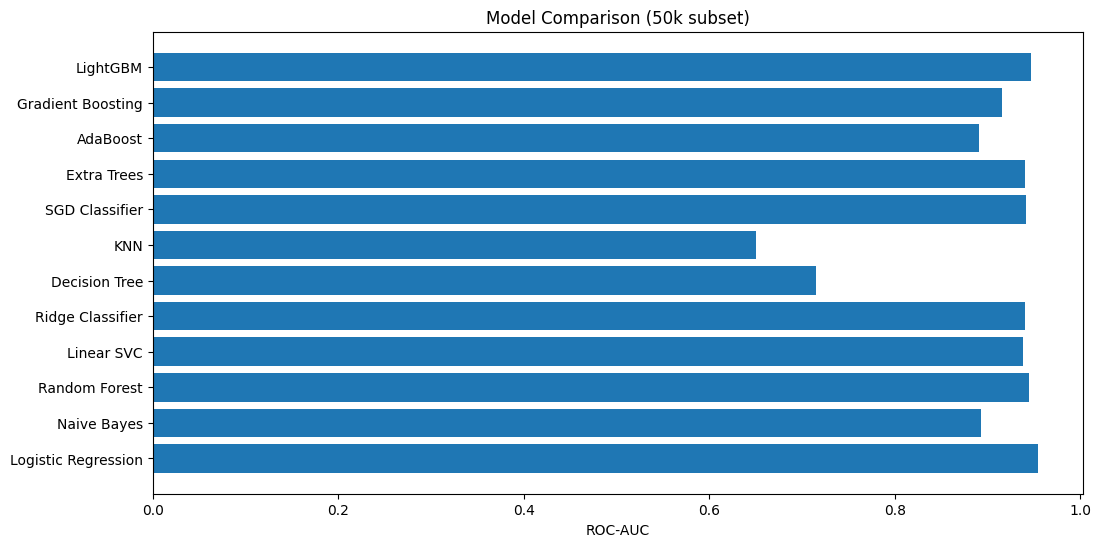

In [40]:
results_df = pd.DataFrame(results, columns=["Model", "ROC-AUC", "Accuracy", "Precision", "Recall", "F1", "Train Time (s)"])
print("\n=== Model Comparison on 50k Subset ===")
print(results_df.sort_values(by="F1", ascending=False))


plt.figure(figsize=(12,6))
plt.barh(results_df["Model"], results_df["ROC-AUC"])
plt.xlabel("ROC-AUC")
plt.title("Model Comparison (50k subset)")
plt.show()

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


MAX_WORDS = 20000
MAX_LEN = 100


tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)


X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_valid_pad = pad_sequences(X_valid_seq, maxlen=MAX_LEN)

In [42]:
def build_lstm_model(input_len, vocab_size, num_labels):
    inputs = Input(shape=(input_len,))
    x = Embedding(vocab_size, 128)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_labels, activation="sigmoid")(x)


    model = Model(inputs, outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


lstm_model = build_lstm_model(MAX_LEN, MAX_WORDS, len(labels))


early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)


history = lstm_model.fit(
    X_train_pad, y_train.values,
    validation_data=(X_valid_pad, y_valid.values),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 123s 434ms/step - accuracy: 0.8565 - loss: 0.3021 - val_accuracy: 0.9819 - val_loss: 0.1434
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 425ms/step - accuracy: 0.9442 - loss: 0.1306 - val_accuracy: 0.9819 - val_loss: 0.1342
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 115s 420ms/step - accuracy: 0.9490 - loss: 0.1129 - val_accuracy: 0.9819 - val_loss: 0.1346
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 115s 420ms/step - accuracy: 0.9251 - loss: 0.1038 - val_accuracy: 0.9756 - val_loss: 0.1345


In [43]:
from sklearn.metrics import f1_score
y_pred_lstm = (lstm_model.predict(X_valid_pad) > 0.5).astype(int)


f1_macro_lstm = f1_score(y_valid, y_pred_lstm, average="macro")
print("LSTM F1-macro:", f1_macro_lstm)

235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step
LSTM F1-macro: 0.4071564459715092



=== Logistic Regression Classification Report ===
               precision    recall  f1-score   support

        toxic       0.90      0.77      0.83      2311
 severe_toxic       0.50      0.21      0.29       246
      obscene       0.90      0.67      0.76      1290
       threat       0.56      0.13      0.22        75
       insult       0.80      0.57      0.66      1241
identity_hate       0.70      0.29      0.41       229

    micro avg       0.86      0.65      0.74      5392
    macro avg       0.72      0.44      0.53      5392
 weighted avg       0.84      0.65      0.73      5392
  samples avg       0.22      0.20      0.20      5392



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


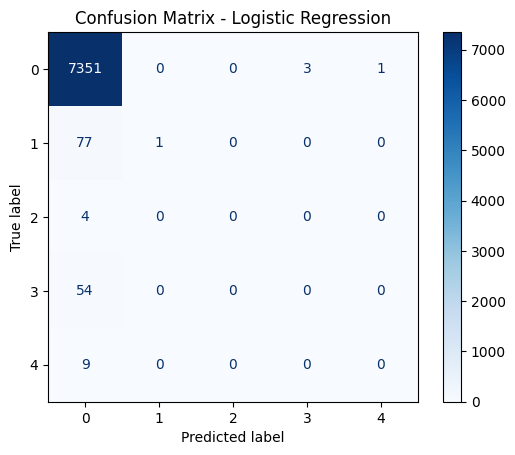


=== LightGBM Classification Report ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predict

               precision    recall  f1-score   support

        toxic       0.90      0.76      0.83      2311
 severe_toxic       0.48      0.20      0.28       246
      obscene       0.88      0.74      0.81      1290
       threat       0.50      0.16      0.24        75
       insult       0.77      0.66      0.71      1241
identity_hate       0.69      0.27      0.39       229

    micro avg       0.85      0.68      0.75      5392
    macro avg       0.70      0.46      0.54      5392
 weighted avg       0.83      0.68      0.74      5392
  samples avg       0.22      0.21      0.20      5392



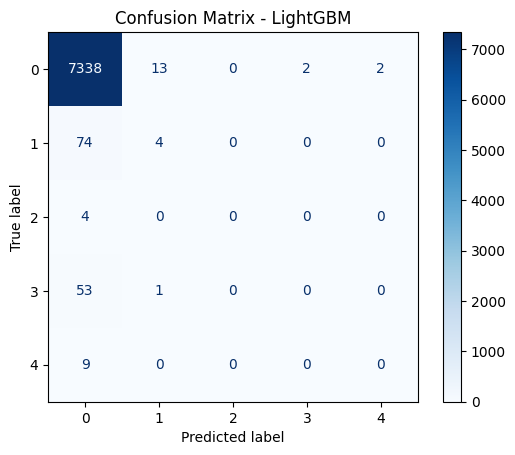


=== Decision Tree Classification Report ===
               precision    recall  f1-score   support

        toxic       0.89      0.59      0.71      2311
 severe_toxic       0.32      0.21      0.25       246
      obscene       0.84      0.71      0.77      1290
       threat       0.38      0.19      0.25        75
       insult       0.72      0.59      0.65      1241
identity_hate       0.53      0.38      0.44       229

    micro avg       0.79      0.59      0.68      5392
    macro avg       0.61      0.44      0.51      5392
 weighted avg       0.79      0.59      0.67      5392
  samples avg       0.18      0.17      0.17      5392



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


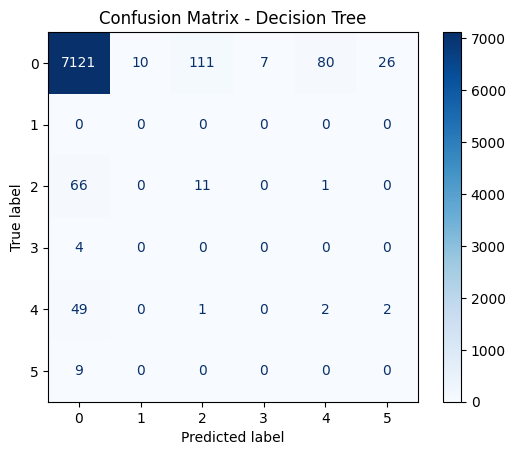

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay


# Pick top 3 by F1
best_models = results_df.sort_values(by="F1", ascending=False).head(3)


for m in best_models["Model"]:
    print(f"\n=== {m} Classification Report ===")


    if m == "LightGBM":
        # Predict label-wise for LightGBM
        preds = []
        for i in range(X_test_tfidf.shape[0]):
            row = []
            for label, lgb in models["LightGBM"].items():
                prob = lgb.predict_proba(X_test_tfidf[i])[:,1][0]
                row.append(1 if prob >= 0.5 else 0)
            preds.append(row)
        y_pred_bin = np.array(preds)
    else:
        clf = models[m]
        if hasattr(clf, "predict_proba"):
            y_pred = clf.predict_proba(X_test_tfidf)
        else:
            y_pred = clf.decision_function(X_test_tfidf)
            y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
        y_pred_bin = (y_pred >= 0.5).astype(int)


    print(classification_report(y_test, y_pred_bin, target_names=labels))


    cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred_bin.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {m}")
    plt.show()

In [46]:
import joblib


# Save best classical model
best_classical = best_models.iloc[0]["Model"]
if best_classical != "LightGBM":
    joblib.dump(models[best_classical], f"best_model_{best_classical}.pkl")
    print(f"Saved {best_classical} as best_model_{best_classical}.pkl")


# Save LSTM
lstm_model.save("best_model_LSTM.h5")
print("Saved LSTM model as best_model_LSTM.h5")

Saved Logistic Regression as best_model_Logistic Regression.pkl
Saved LSTM model as best_model_LSTM.h5


In [53]:
def compare_models_on_texts(texts):
    clean_texts = [clean_text(t) for t in texts]
    X_tfidf = vectorizer.transform(clean_texts)
    seq = tokenizer.texts_to_sequences(clean_texts)
    pad = pad_sequences(seq, maxlen=MAX_LEN)


    predictions = {}
    for name in best_models["Model"]:
        if name in models: # Check if model exists in models dictionary
            if name == "LightGBM":
                preds = []
                for i in range(X_tfidf.shape[0]):
                    labels_on = []
                    for label, lgb in models["LightGBM"].items():
                        prob = lgb.predict_proba(X_tfidf[i])[:,1][0]
                        if prob > 0.5:
                            labels_on.append(label)
                    preds.append(labels_on if labels_on else ["clean"])
                predictions[name] = preds


            elif name == "LSTM":
                # Check if lstm_model exists as a global variable
                if 'lstm_model' in globals() and lstm_model is not None:
                    preds = (lstm_model.predict(pad) > 0.5).astype(int)
                    pred_labels = []
                    for p in preds:
                        pred_labels.append([labels[i] for i, v in enumerate(p) if v==1] or ["clean"])
                    predictions[name] = pred_labels
                else:
                    print(f"LSTM model not found or not trained. Skipping {name}.")


            else:
                clf = models[name]
                if hasattr(clf, "predict_proba"):
                    probs = clf.predict_proba(X_tfidf)
                else:
                    probs = clf.decision_function(X_tfidf)
                    probs = (probs - probs.min()) / (probs.max() - probs.min())
                preds = []
                for row in probs:
                    labels_on = [labels[i] for i, p in enumerate(row) if p > 0.5]
                    preds.append(labels_on if labels_on else ["clean"])
                predictions[name] = preds
        else:
            print(f"Model '{name}' not found in 'models' dictionary. Skipping.")


    return predictions

In [55]:
test_comments = [
"You are an idiot and I hate you!",
"Have a nice day my friend!",
"I will kill you tonight",
"This is a beautiful day son of bitch",
"Thank you for your help fuck "
]


final_preds = compare_models_on_texts(test_comments)
for model_name, preds in final_preds.items():
    print(f"\n=== {model_name} Predictions ===")
    for txt, pred in zip(test_comments, preds):
        print(f"Text: {txt}\n → {pred}")


=== Logistic Regression Predictions ===
Text: You are an idiot and I hate you!
 → ['toxic', 'obscene', 'insult']
Text: Have a nice day my friend!
 → ['clean']
Text: I will kill you tonight
 → ['toxic', 'threat']
Text: This is a beautiful day son of bitch
 → ['toxic', 'obscene', 'insult']
Text: Thank you for your help fuck 
 → ['toxic', 'obscene']

=== LightGBM Predictions ===
Text: You are an idiot and I hate you!
 → ['toxic', 'insult']
Text: Have a nice day my friend!
 → ['clean']
Text: I will kill you tonight
 → ['toxic']
Text: This is a beautiful day son of bitch
 → ['toxic', 'obscene', 'insult']
Text: Thank you for your help fuck 
 → ['toxic', 'obscene']

=== Decision Tree Predictions ===
Text: You are an idiot and I hate you!
 → ['toxic', 'insult']
Text: Have a nice day my friend!
 → ['clean']
Text: I will kill you tonight
 → ['toxic']
Text: This is a beautiful day son of bitch
 → ['toxic', 'obscene', 'insult']
Text: Thank you for your help fuck 
 → ['toxic', 'obscene', 'insult']